# CS 342 Final Project - Letter Recognition CNN

Mrityunjay Mishra (eid: mm94424), Mihir Suvarna (eid: mms5776), Daniel Sialm (eid: dhs833)

## Project Description

This project aims to create a convolutional neural network (CNN) for the task of letter recognition. The task of letter recognition, or more generally speaking, text recognition (also known as optical character recognition, or OCR) has gained much importance in recent years due to emerging applications. For example, OCR software can be used to convert handwritten text into digital text and robots use cameras to read signs in their environment. Letter recognition is a subtask of text recognition with wide applications as well - iPhones use letter recognition to convert handwritten characters to text. Due to the increasing importance of these tasks, we aim to create a robust CNN that is able to correctly classify handwritten and digital letters.

In [1]:
# Run these two blocks to load important libraries and set things up
from letter_recognition_functions import *
from ttf_to_png import *
%matplotlib inline

## Dataset

We collected handwritten letters from 23 students, each of whom wrote the alphabet 10 times. This gave us about 6K data points to train and test our model.

In [2]:
letter_to_label = dict()
classes = ['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
for i in range(len(classes)):
    letter_to_label[classes[i]] = i
print(letter_to_label)

{'N/A': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [40]:
src_dir = 'data/collected_ttfs'
dst_dir = 'data/collected_letters_pngs'
num_ttfs = convert_ttf(src_dir, dst_dir)

Processed P18-Regular.ttf
Processed P0-Regular.ttf
Processed P11-Regular.ttf
Processed P9-Regular.ttf
Processed P23-Regular.ttf
Processed P14-Regular.ttf
Processed P5-Regular.ttf
Processed P6-Regular.ttf
Processed P17-Regular.ttf
Processed P20-Regular.ttf
Processed P12-Regular.ttf
Processed P3-Regular.ttf
Processed P4-Regular.ttf
Processed P15-Regular.ttf
Processed P22-Regular.ttf
Processed P10-Regular.ttf
Processed P8-Regular.ttf
Processed P19-Regular.ttf
Processed P1-Regular.ttf
Processed P2-Regular.ttf
Processed P13-Regular.ttf
Processed P21-Regular.ttf
Processed P16-Regular.ttf
Processed P7-Regular.ttf


In [41]:
src_dir = 'data/collected_letters_pngs'
transform = transforms.ToTensor()

num_train = int(0.7 * num_ttfs)
num_val = (num_ttfs - num_train) // 2

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1]
    # gets which person wrote this font
    p_val = int(ftitle.split("_")[0].split("-")[0][1:])
    im = Image.open(f).convert('L')
    
    if p_val <= num_train:
        imgs_train += transform(im).detach().tolist()
        labels_train.append(letter_to_label[letter])
    elif p_val <= num_train + num_val:
        imgs_val += transform(im).detach().tolist()
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test += transform(im).detach().tolist()
        labels_test.append(letter_to_label[letter])

In [42]:
train_loader_collected = create_loader(imgs_train, labels_train)
val_loader_collected = create_loader(imgs_val, labels_val)
test_loader_collected = create_loader(imgs_test, labels_test)

Label: s


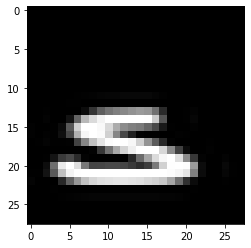

In [43]:
# Visualization for our collected dataset
img, label = get_input(train_loader_collected)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

## Defining a basic LetterCNN

We define a basic CNN with 1 convolutional layer, 1 MaxPool layer, a ReLU activation and finally a fully connected layer for our model. This model will be used throughout our prelimenary expriments (i.e. before our computational experiments).

In [44]:
class letterCNN(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

## Testing the basic LetterCNN

In [45]:
basic_model_collected = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model_collected.parameters(), lr=1e-3)
train_network(basic_model_collected, train_loader_collected, val_loader_collected, criterion, optimizer, nepoch=10)

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 0
 Train loss: 3.25055
   Val loss: 3.13403

EPOCH 1
 Train loss: 2.98430
   Val loss: 2.89094

EPOCH 2
 Train loss: 2.61690
   Val loss: 2.63182

EPOCH 3
 Train loss: 2.22144
   Val loss: 2.35645

EPOCH 4
 Train loss: 1.90629
   Val loss: 2.13534

EPOCH 5
 Train loss: 1.66781
   Val loss: 2.13455

EPOCH 6
 Train loss: 1.50729
   Val loss: 2.06651

EPOCH 7
 Train loss: 1.39178
   Val loss: 2.00800

EPOCH 8
 Train loss: 1.29860
   Val loss: 2.07046

EPOCH 9
 Train loss: 1.22753
   Val loss: 1.96096



Test accuracy: 46.154


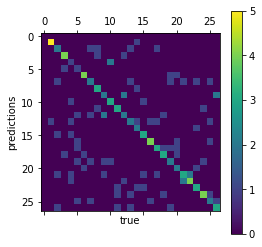

In [46]:
acc, true, pred = test_network(basic_model_collected, test_loader_collected)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model_collected.classes), pred, true)

We see quite a bit of overfitting (since the validation loss is not converging and, in fact, even increasing). This naturally causes our accuracy to be quite low. While this accuracy is still quite good - $48.718 / (1 / 26) = 12.67$ times increase in accuracy from just taking a random guess - we can still do better. The reason for this poor performance is because only a few people's data was obtained. This causes our model to be biased towards the the handwriting of a few people and prevents it from generalizing well. Thus, we will combine our dataset with the EMNIST dataset to create a better model.

## EMNIST Dataset

In [47]:
# Download the EMNIST dataset and load it as tensors
from torchvision import datasets, transforms

save_dir = 'EMNIST'

transform = transforms.ToTensor() # Convert the image into a torch tensor.

train_set = datasets.EMNIST(save_dir, split="letters", download=True, train=True, transform=transform)
test_set = datasets.EMNIST(save_dir, split="letters", download=True, train=False, transform=transform)

print(train_set)
print(test_set)

Dataset EMNIST
    Number of datapoints: 124800
    Root location: EMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset EMNIST
    Number of datapoints: 20800
    Root location: EMNIST
    Split: Test
    StandardTransform
Transform: ToTensor()


In [48]:
# Create samplers for the training and validation sets
from torch.utils.data.sampler import SubsetRandomSampler

ncollected = len(train_loader_collected + val_loader_collected) * train_loader.collected.batch_size

ntotal = 60000
ntrain = int(0.70*ntotal)
nval = ntotal - ntrain

val_ix = np.random.choice(range(ntotal), size=nval, replace=False)
train_ix = list(set(range(ntotal)) - set(val_ix))

train_sampler = SubsetRandomSampler(train_ix)
val_sampler = SubsetRandomSampler(val_ix)

In [49]:
# initialize the data sets
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

In [77]:
ncollected = len(train_loader_collected) + len(val_loader_collected) * train_loader.collected.batch_size
print(len(train_loader) * 64)
print(len(val_loader) * 64)
print(len(test_loader) * 64)

AttributeError: 'DataLoader' object has no attribute 'collected'

Label: m


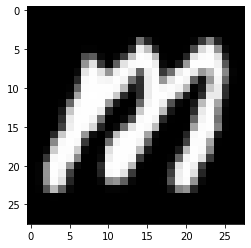

In [50]:
# Visualization EMNIST
img, label = get_input(train_loader)
# print label
index = 0
plt.imshow(img.reshape((28, 28)).T, cmap='Greys_r')
print("Label: %s" % classes[label])

## Combining EMNIST with our Data

In [51]:
combined_train_loader = combine_loaders(train_loader, train_loader_collected, fromEMNIST=True)
combined_val_loader = combine_loaders(val_loader, val_loader_collected, fromEMNIST=True)
combined_test_loader = combine_loaders(test_loader, test_loader_collected, fromEMNIST=True)

Label: k


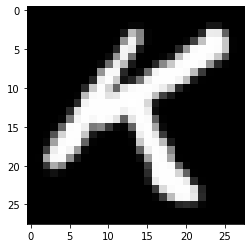

In [52]:
# Verifying combined
img, label = get_input(combined_test_loader)
# print label
index = 0
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

## Making a new LetterCNN on the Combined Dataset

In [ ]:
basic_model = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(basic_model.parameters(), lr=1e-3)
train_network(basic_model, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(basic_model, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(basic_model.classes), pred, true)

We see immediate improvement in our results. The new model does not overfit (since the validation loss decreases) and generalizes quite well, giving us an accuracy of about 86%, an increase of about 79% in accuracy compared to our older model. This shows that our model works well if a good dataset is provided. 

## Computational Experiment 1 - Regularization

Our first set of computational experiments will deal with better regularization of our model in hopes of creating a more generalized model. 

### 1a) Regularization through data augmentation - add digital fonts

For this experiment, we add digital fonts to our dataset. Specifically, we take about 100 different fonts and add their characters to our dataset. We hypothesize that this will increase the accuracy of our model.

In [53]:
src_dir = 'data/digital_ttfs'
dst_dir = 'data/digital_letters_pngs'
num_ttfs = convert_ttf(src_dir, dst_dir)

Processed Georgia.ttf
Processed Bodoni 72 Smallcaps Book.ttf
Processed Silom.ttf
Processed Bradley Hand Bold.ttf
Ignored .DS_Store
Processed AppleGothic.ttf
Processed Trebuchet MS.ttf
Processed Academy Engraved LET Fonts.ttf
Processed Trattatello.ttf
Processed BigCaslon.ttf
Processed Lao Sangam MN.ttf
Processed Luminari.ttf
Processed Times New Roman.ttf
Processed Brush Script.ttf


1 extra bytes in post.stringData array


Processed Chalkduster.ttf
Processed Apple Chancery.ttf
Processed AppleMyungjo.ttf
Processed NotoSansCarian-Regular.ttf
Processed Courier New.ttf
Processed Skia.ttf
Processed Impact.ttf
Processed NotoSansElbasan-Regular.ttf
Processed PartyLET-plain.ttf


1 extra bytes in post.stringData array


Processed Arial.ttf
Processed Ayuthaya.ttf
Processed Khmer Sangam MN.ttf
Processed Comic Sans MS.ttf
Processed DIN Alternate Bold.ttf
Processed Sathu.ttf
Processed Tahoma.ttf
Processed PlantagenetCherokee.ttf


1 extra bytes in post.stringData array


Processed Microsoft Sans Serif.ttf
Processed Krungthep.ttf


1 extra bytes in post.stringData array


Processed Andale Mono.ttf
Processed Herculanum.ttf
Processed Verdana.ttf


In [54]:
src_dir = "data/digital_letters_pngs"

num_train = int(0.7 * num_ttfs)
num_val = (num_ttfs - num_train) // 2

imgs_train = []
imgs_val = []
imgs_test = []
labels_train = []
labels_val = []
labels_test = []
idx = 0
for f in glob.glob(os.path.join(src_dir, '*.png')):
    ftitle, fext = os.path.splitext(os.path.basename(f))
    letter = ftitle.split("_")[1].lower()
    im = Image.open(f).convert('L')

    if idx < num_train:
        imgs_train += transform(im).detach().tolist()
        labels_train.append(letter_to_label[letter])
    elif idx < num_train + num_val:
        imgs_val += transform(im).detach().tolist()
        labels_val.append(letter_to_label[letter])
    else:
        imgs_test += transform(im).detach().tolist()
        labels_test.append(letter_to_label[letter])
    
    idx += 1

In [55]:
train_loader_digital = create_loader(imgs_train, labels_train)
val_loader_digital = create_loader(imgs_val, labels_val)
test_loader_digital = create_loader(imgs_test, labels_test)

Label: g


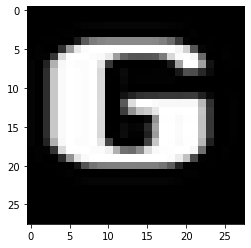

In [63]:
# Visualization of a digital font
img, label = get_input(train_loader_digital)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [64]:
# Combine digital with other data
combined_train_digital_loader = combine_loaders(combined_train_loader, train_loader_digital)
combined_val_digital_loader = combine_loaders(combined_val_loader, val_loader_digital)
combined_test_digital_loader = combine_loaders(combined_test_loader, test_loader_digital)

Label: k


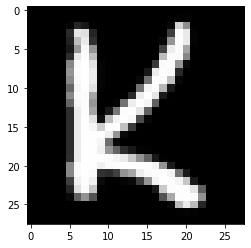

In [72]:
# Verifiying combined
img, label = get_input(combined_test_digital_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [ ]:
# Train model with augmented data
model_digital = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_digital.parameters(), lr=1e-3)
train_network(model_digital, combined_train_digital_loader, combined_val_digital_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_digital, combined_test_digital_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_digital.classes), pred, true)

The accuracy of the model with the augmented data did not improve (in fact, it decreased by about 0.4%). It is possible that this happened because we only included 100 fonts - we believe that including more fonts in our dataset should improve the accuracy of our model. However, given current results, it is reasonable to say that the improvement in accuracy will not be very significant even if more fonts are added. 

### 1b) Regularization through dropout

We hypothesize that adding dropout will decrease the accuracy of our model because each image is simply a 28 x 28 image of a letter, and dropping out even the smallest learned feature for a small image should impact the accuracy negatively.

In [ ]:
class letterCNNDropout(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(p=0.2),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [ ]:
model_dropout = letterCNNDropout(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=1e-3)
train_network(model_dropout, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_dropout, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_dropout.classes), pred, true)

As hypothesized, the accuracy of our model did drop using dropout.

### 1c) Regularization through Average Pooling

We hypothesize that the accuracy of our model will stay about the same with average pooling. We believe this to be the case because we have a network with just one convolutional layer which learns on fairly small images. 

In [ ]:
# Visualizing the combined dataset 
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

In [ ]:
# visualize kernels with max pooling
conv_out = basic_model.layers[0](img)
_ = display_pool_outputs(basic_model.layers[1], conv_out)

We see that the kernels are a little blotchy. This is to be expected as a result of max pooling. The learned kernels with average pooling should be a little smoother. 

In [ ]:
class letterCNNAvgPool(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.AvgPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1152, len(self.classes))
        )
            
    def forward(self, x):
        output = self.layers(x)
        return output

In [ ]:
model_avgpool = letterCNNAvgPool(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_avgpool.parameters(), lr=1e-3)
train_network(model_avgpool, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_avgpool, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_avgpool.classes), pred, true)

In [ ]:
# visualize average pooling
conv_out = model_avgpool.layers[0](img)
_ = display_pool_outputs(model_avgpool.layers[1], conv_out)

The learned kernels for average pooling are smoother than the learned kernels for max pooling, as expected. As hypothesized, the accuracy of our model did not improve with average pooling. However, it is interesting that the accuracy decreased a bit with average pooling. This suggests that, for the task of letter recognition, max pooling is a better strategy than average pooling. 

### 1d) Regularization through Early Stopping

As our final experiment for the first computational experiment, we implement early stopping. We hypothesize that early stopping should improve the accuracy marginally. 

In [ ]:
model_early_stopping = letterCNN(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_early_stopping.parameters(), lr=1e-3)
train_network(model_early_stopping, combined_train_loader, combined_val_loader, criterion, optimizer, early_stopping=True)

In [ ]:
acc, true, pred = test_network(model_early_stopping, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_early_stopping.classes), pred, true)

The accuracy of our model with early stopping did not improve and stayed about the same. 

All these computational experiments show that, as defined, our `letterCNN` is actually well defined and supports a good amount of generalization. To get good results, then, we must pick the dataset carefully so that our model generalizes to a variety of handwriting and font styles. 

## Computational Experiment 2 - Architecture

As our second computational experiment, we will visualize the learned kernels of our basic model and then change the architecture to create a new model in hopes of creating a more accurate network. 

### Visualizing previous kernels

In [ ]:
# extract the weights from the learned model
conv1wt = basic_model.layers[0].weight.data.numpy()
display_kernels(conv1wt)

It seems that in our basic model, the kernels are learning to identify specific edge types within letters. For example, in Kernel 3, it seems that the model is learning to identify horizontal edges while in Kernel 6 the model is learning to identify vertical edges. Based upon this, we hypothesize that adding a second convolutional layer to our current model will help it learn the features/characterisitics of each letter better.

### 2a) Double Convolutional Layer

In [ ]:
class letterCNNDouble(nn.Module):
    def __init__(self, classes):
        super().__init__()
        self.classes = classes
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=64, kernel_size=(5,5), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1024, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

In [ ]:
model_double_layer = letterCNNDouble(classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_double_layer.parameters(), lr=1e-3)
train_network(model_double_layer, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_double_layer, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_double_layer.classes), pred, true)

As we can see, adding a seecond layer did indeed increase the accuracy by about 4% as per our hypothesis.

In [ ]:
# extract the weights from the learned model
conv2wtsfirst = model_double_layer.layers[0].weight.data.numpy()
display_kernels(conv2wtsfirst)

The first layer is still learning the hard edges of each letter as the single convolutional layer network (i.e. our basic model).

In [ ]:
# extract the weights from the learned model
conv2wtssecond = model_double_layer.layers[3].weight.data.numpy()
display_kernels(conv2wtssecond)

The second layer seems to be learning more precise/specific features. Note that we only display the first channel of each of the 64 channels in the second convolution layer in `letterCNNDouble`. Still, it is quite obvious that the second layer's kernels are learning more precise features. It seems that the second layer is starting to learn more nuances between the edges of each letter - however, that is much harder to confirm. Still, as hypothesized, adding a second convolution layer to our basic CNN helped the new model learn more precise features about each letter and this in turn increased the accuracy of our new model. 

### 2b) Changing the Kernel Size

In [ ]:
class letterCNNKernel(nn.Module):
    def __init__(self, classes, size):
        super().__init__()
        self.classes = classes
        output_size = (((28 - size) + 1) // 2) ** 2 * 8 
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(size,size), stride=1),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(output_size, len(self.classes))
        )
            
    def forward(self, x):
        return self.layers(x)

#### Size 3 kernel

In [ ]:
model_kernel_3 = letterCNNKernel(classes, 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_3.parameters(), lr=1e-3)
train_network(model_kernel_3, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_kernel_3, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_3.classes), pred, true)

In [ ]:
# extract the weights from the learned model
convk3wts = model_kernel_3.layers[0].weight.data.numpy()
display_kernels(convk3wts)

#### Size 8 kernel

In [ ]:
model_kernel_8 = letterCNNKernel(classes, 8)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_8.parameters(), lr=1e-3)
train_network(model_kernel_8, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_kernel_8, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_8.classes), pred, true)

In [ ]:
# extract the weights from the learned model
convk8wts = model_kernel_8.layers[0].weight.data.numpy()
display_kernels(convk8wts)

#### Size 11 kernel

In [ ]:
model_kernel_11 = letterCNNKernel(classes, 11)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_kernel_11.parameters(), lr=1e-3)
train_network(model_kernel_11, combined_train_loader, combined_val_loader, criterion, optimizer, nepoch=10)

In [ ]:
acc, true, pred = test_network(model_kernel_11, combined_test_loader)
print('Test accuracy: %0.3f' % acc)

display_contingency_matrix(len(model_kernel_11.classes), pred, true)

In [ ]:
# extract the weights from the learned model
convk11wts = model_kernel_11.layers[0].weight.data.numpy()
display_kernels(convk11wts)

## Optimized Inputs

In [ ]:
optimized_inputs_kernel_3 = get_optimized_inputs(model_kernel_3, nepochs=1000)
optimized_inputs_kernel_5 = get_optimized_inputs(basic_model, nepochs=1000)
optimized_inputs_kernel_8 = get_optimized_inputs(model_kernel_8, nepochs=1000)
optimized_inputs_kernel_11 = get_optimized_inputs(model_kernel_11, nepochs=1000)
optimized_inputs_double_conv = get_optimized_inputs(model_double_layer, nepochs=1000, validate_loss=True)

In [ ]:
display_optimized_inputs(optimized_inputs_kernel_3)

In [ ]:
display_optimized_inputs(optimized_inputs_kernel_5)

In [ ]:
display_optimized_inputs(optimized_inputs_kernel_8)

In [ ]:
display_optimized_inputs(optimized_inputs_kernel_11)

In [ ]:
display_optimized_inputs(optimized_inputs_double_conv)

## Additional Visualizations

We provide some additional visualizations here for reference. 

In [ ]:
# Visualizing a different letter from the combined dataset
img, label = get_input(combined_train_loader)
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')
print("Label: %s" % classes[label])

#### Single Convolution Layer

In [ ]:
# Visualizing the learned kernels for the sinlge convolutional layer network
conv1_layer = basic_model.layers[0]
display_kernels(conv1_layer.weight.data.numpy())

In [ ]:
# Visualizing convolved outputs for the sinlge convolutional layer network
conv_outs = display_conv_outputs(conv1_layer, img)

In [ ]:
# Visualizing the max pooling layer outputs for the sinlge convolutional layer network
_ = display_pool_outputs(basic_model.layers[1], conv_outs)

#### Double Convolutional Layer

In [ ]:
# Visualizing the learned kernels of the first convolution layer of the double covolutional network
conv2_layer1 = model_double_layer.layers[0]
display_kernels(conv2_layer1.weight.data.numpy())

In [ ]:
# Visualizing the convolved outputs of first convolution layer of the double covolutional network
outs_layer1 = display_conv_outputs(model_double_layer.layers[0], img)

In [ ]:
# Visualizing the max pool outputs of the first max pool layer of the double covolutional network
pooled_layer1 = display_pool_outputs(model_double_layer.layers[1], outs_layer1)

In [ ]:
# Visualizing the learned kernels of the second convolution layer of the double covolutional network
conv2_layer2 = model_double_layer.layers[3]
display_kernels(conv2_layer2.weight.data.numpy())

In [ ]:
# Visualizing the convolved outputs of the second convolution layer of the double covolutional network
inputs_layer2 = model_double_layer.layers[2](pooled_layer1)
outs_layer2 = display_conv_outputs(model_double_layer.layers[3], inputs_layer2)

In [ ]:
# Visualizing the max pool outputs of second max pool layer of the double covolutional network
_ = display_pool_outputs(model_double_layer.layers[4], outs_layer2)